In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
import numpy as np
%matplotlib inline

# Preprocessing the dataset

In [103]:
#grouping together the length column into short, medium, and long
length=[] #short, medium, and long equal <60, between 60 and 120, and >120, respectively
games=pd.read_csv("gamesdataset.csv", encoding="latin1")
games=games[games.notnull()]
games.minplayers=games.minplayers.astype(str)
games.maxplayers=games.maxplayers.astype(str)
games["range"]=games.minplayers+"-"+games.maxplayers
games=games[games.playingtime.notnull()]
for i in games.playingtime:
    if i < 60 or i == 60:
        length.append("shortgame")
    if i > 60 and i <=120:
        length.append("mediumgame")
    if i >120:
        length.append("longgame")
    if i == np.nan:
        length.append(np.nan)
games["length"]=length  #turned as many things as possible into factors/categorical data

In [65]:
#create the gametype response variable
games.year=games.year.astype(int)
gametype=[]
for i in games.year:
    if i > 2000: 
        gametype.append("Euro")
    if i == 2000:
        gametype.append("Euro")
    if i < 2000:
        gametype.append("War")
games["gametype"]= gametype

In [66]:
#turned amount of players into three levels
plamount=[]
games["avgplayers"]=games.maxplayers.astype("float")+games.minplayers.astype("float")
for i in games.avgplayers:
    if i < 3 or i == 3:
        plamount.append("fewplayers") #1-2 person games
    if i > 3 and i < 9:
        plamount.append("averageplayers") #assuming a max of 3-5 players
    if i > 8:
        plamount.append("manyplayers")
games["playeramount"]=plamount

In [67]:
games.category=games.category.astype(str)
games.publisher=games.publisher.astype(str)
games.mechanic=games.mechanic.astype(str)
cats=games.category.str.get_dummies(sep=",")
mech=games.mechanic.str.get_dummies(sep=",")
p=games.publisher.value_counts()
big_list=p[(p>90) | (p ==90)].index
middle_list=p[(p<90) & (p>24)].index
small_list=p[(p==24) | (p<24)]
big_list=big_list[2:]
y=big_list[15]
big_list=big_list[big_list !=y]
#categorized publishers as  big, medium, and small

In [68]:
publisher_size=[]
for i in games.publisher:
    if i in big_list:
        publisher_size.append("Large Publisher")
    if i in middle_list:
        publisher_size.append("Medium Size Publisher")
    if i in small_list:
        publisher_size.append("Small/Mixed Publisher")
    if i == "(Self-Published)" or i == "(Web published)" or i == "(Self-Published),(Web published)":
        publisher_size.append("Self-Published")  #included self/web published as a separate variable
games["publisher_size"]=publisher_size

In [69]:
pub=games.publisher_size.str.get_dummies()
pa=games.playeramount.str.get_dummies()
length=games.length.str.get_dummies()
gt=games.gametype.str.get_dummies()
gt.War=gt.War.astype(float)
#turned all of these columns into dummy variables

In [70]:
df=games.copy() #copied out games made a separate dataframe for data analysis
df=df.drop(["id",'description', 'image', 'maxplayers', 'maxplaytime', 'minage',
       'minplayers', 'minplaytime', 'name', 'playingtime', 'thumbnail', 'year',
       'boardgameartist', 'category', 'compilation', 'designer',
       'implementation', 'integration', 'mechanic', 'publisher', 'stats.subtype.boardgame.bayesaverage',
       'stats.subtype.boardgame.pos'], axis=1) #things that are irrelevant in this situation
dfy=df[['owned', 'average', 'geekscore', 'wanting', 'weight', 'gametype']] #built a df with y data
df=df.drop(['range', "length", "avgplayers", 'gametype', 'publisher_size', 'playeramount'], axis=1) #dropped duplicate data
df_with_dummies=pd.concat([df, length,cats,pa, mech, pub], axis=1) #added all the dummy variables to the datase
dfaverage=pd.concat([df, length,cats,pa, mech, pub, gt], axis=1)
dfaverage=dfaverage.drop("average", axis=1)
#built a series of dataframes for my equations, so I could do some feature selection
dfgs=pd.concat([df, length,cats,pa, mech, pub, gt], axis=1)
dfgs=dfgs[dfgs.geekscore > 0]
dfgs=dfgs.drop("geekscore", axis=1)#made a separate version for geekscore, since so many games lack a geekscore
#make everything into one database
gsy=dfy[dfy.geekscore >0]

# Geekscore model

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5, random_state=0)
from sklearn.model_selection import train_test_split
#imported some things from sklearn

I started with a simple Linear Regression model, and have left it in as a baseline

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_trainval, X_test, y_trainval, y_test=train_test_split(dfgs.values, gsy.geekscore, random_state=0)
lr=LinearRegression().fit(X_trainval, y_trainval)
print("Training Set Score (R Squared): {}".format(lr.score(X_trainval, y_trainval)))
print("Test Set Score (R Squared): {}".format(lr.score(X_test, y_test)))
y_pred=lr.predict(X_test)
print("Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
x=mean_squared_error(y_test, y_pred)

Training Set Score (R Squared): 0.8104316354332655
Test Set Score (R Squared): 0.7830551667749369
Mean Squared Error: 0.017914905325386928


Geekscore Regression Model--a Random Forest Regressor

In [24]:
X_train, X_test, y_train, y_test=train_test_split(dfgs.values, gsy.geekscore, random_state=1, train_size=.75) #splitting the data

In [18]:
from sklearn.model_selection import GridSearchCV
parameters={"min_samples_leaf":[1,2,3,4,5,6,7,8], "max_depth":[10,11,12,13,14], "max_leaf_nodes":[90, 91,92,93,94,95, 96,98,99,100]}
rfr=RandomForestRegressor(n_estimators=5)
clf=GridSearchCV(rfr, parameters, cv=kfold, scoring="neg_mean_squared_error", n_jobs=4)
clf.fit(X_train, y_train)
print(clf.best_params_) #finding the best parameters

{'max_depth': 11, 'max_leaf_nodes': 98, 'min_samples_leaf': 2}


In [31]:
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
rf=RandomForestRegressor(n_estimators =100,max_depth=12, min_samples_leaf=2, max_leaf_nodes=95)
rfr=rf.fit(X_train, y_train)
y_predtrain=rfr.predict(X_train)
trainmse=mean_squared_error(y_train, y_predtrain)
rmsetrain=sqrt(trainmse)
print("Root Mean Squared Error on Training Data: {}".format((rmsetrain)))
y_pred=rfr.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
rmsetest=mse**0.5 #turned mse into rmse
print("Root Mean Squared Error on Test Data: {}".format(rmsetest))
#built the model

Root Mean Squared Error on Training Data: 0.023022710400284016
Root Mean Squared Error on Test Data: 0.03631883462324047


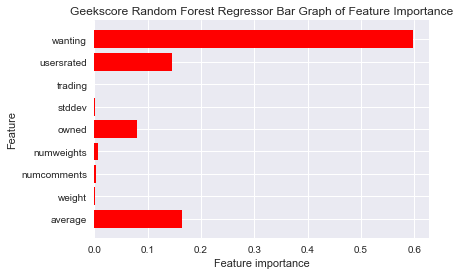

In [22]:
x=rfr.feature_importances_ > 0.0001
features=dfgs.columns[x]
coefficients=list(rfr.feature_importances_[x])
gsy.geekscore.mean()
gsy.geekscore.median()
n_features = dfgs.columns[x].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="red")
plt.yticks(np.arange(n_features), features)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Geekscore Random Forest Regressor Bar Graph of Feature Importance")
#graph of feature importance

# Game Average Regression Model

In [74]:
dfaverage=dfaverage.drop(["Euro", "War"], axis=1) #drop Euor and War

In [75]:
#calculate on a simple Linear regression model
from sklearn.metrics import mean_squared_error
from math import sqrt
X_trainval, X_test, y_trainval, y_test=train_test_split(dfaverage.values, dfy.average, random_state=0)
lr=LinearRegression().fit(X_trainval, y_trainval)
y_predtrain=lr.predict(X_trainval)
print("Root Mean Squared Error on Training data: {}".format(sqrt(mean_squared_error(y_trainval, y_predtrain))))
y_pred=lr.predict(X_test)
print("Root Mean Squared Error on Test Data: {}".format(sqrt(mean_squared_error(y_test, y_pred))))

Root Mean Squared Error on Training data: 0.8782041650839753
Root Mean Squared Error on Test Data: 0.9798208472291914


In [76]:
#use lasso technique, since it produces interesting data for category and mechanics
from sklearn.linear_model import Lasso
#lasso technique on average
bestscore=5
best_alpha=0
X_train, X_val, y_train, y_val=train_test_split(X_trainval, y_trainval, random_state=0)
alphas=[0.00001, 0.0001, 0.001, 0.01, 0.1]
for alpha in alphas:
    lasso=Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_pred=lasso.predict(X_val)
    score=mean_squared_error(y_val, y_pred)
    if score < bestscore:
        bestscore=score
        best_alpha=alpha
print("Best RMSE from CV: {}".format(sqrt(bestscore)))
print("Best alpha from CV: {}".format(best_alpha)) #parameter tuning of alpha

Best RMSE from CV: 0.8844098528946752
Best alpha from CV: 0.0001


In [77]:
lasso=Lasso(alpha=best_alpha, max_iter=100000).fit(X_trainval, y_trainval)
print("Number of features used: {}".format(np.sum(lasso.coef_!=0)))
y_predtrain=lasso.predict(X_trainval)
print("Root Mean Squared Error on train data: {}".format(sqrt(mean_squared_error(y_trainval, y_predtrain))))
y_pred=lasso.predict(X_test)
print("Root Mean Squared Error on test data: {}".format(sqrt(mean_squared_error(y_test, y_pred))))
#model rmse

Number of features used: 146
Root Mean Squared Error on train data: 0.8782871750708969
Root Mean Squared Error on test data: 0.8892818363281227


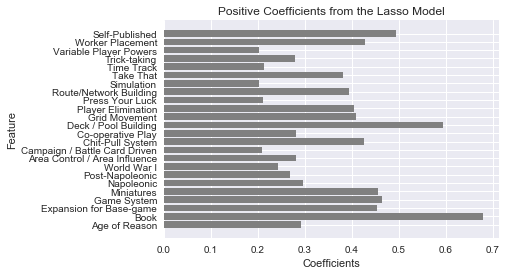

In [78]:
#positive coefficients in the model that increase average
x=lasso.coef_ > 0.2
features=dfaverage.columns[x]
coefficients=list(lasso.coef_[x])
n_features = dfaverage.columns[x].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="grey")
plt.yticks(np.arange(n_features), features)
plt.xlabel("Coefficients")
plt.ylabel("Feature")
plt.title("Positive Coefficients from the Lasso Model")


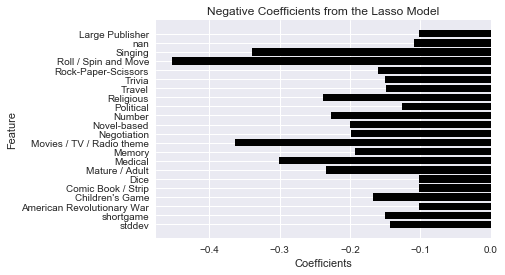

In [79]:
#negative coefficients in the model that decrease the average
x=lasso.coef_ < -0.1
features=dfaverage.columns[x]
coefficients=list(lasso.coef_[x])
n_features = dfaverage.columns[x].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="black")
plt.yticks(np.arange(n_features), features)
plt.xlabel("Coefficients")
plt.ylabel("Feature")
plt.title("Negative Coefficients from the Lasso Model")

In [ ]:
#feature selection on the random forest model--some purposeful redundancy here as this takes a long time to rn
X_train, X_test, y_train, y_test=train_test_split(dfaverage.values, dfy.average, random_state=1, train_size=.7)
#random forest for averages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters={"min_samples_leaf":[15,16,17], "max_depth":[14,15,16,17], "max_leaf_nodes":[102,103,104,105,110,120]}
rfr=RandomForestRegressor(n_estimators=5)
clf=GridSearchCV(rfr, parameters, cv=kfold, scoring="neg_mean_squared_error", n_jobs=4)
clf.fit(X_train, y_train)
print(clf.best_params_)

In [81]:
#the random forest model
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test=train_test_split(dfaverage.values, dfy.average, random_state=1, train_size=.7)
rf=RandomForestRegressor(n_estimators =500,max_depth=16, min_samples_leaf=15, max_leaf_nodes=110, n_jobs=3)
rfr=rf.fit(X_train, y_train)
y_predtrain=rfr.predict(X_train)
rmsetrain=sqrt(mean_squared_error(y_train, y_predtrain))
print("Root Mean Squared Error on Training Data: {}".format(rmsetrain))
y_pred=rfr.predict(X_test)
rmsetest=sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error on Test Data: {}".format(rmsetest))


Root Mean Squared Error on Training Data: 0.7132865177308378
Root Mean Squared Error on Test Data: 0.7498824349076901


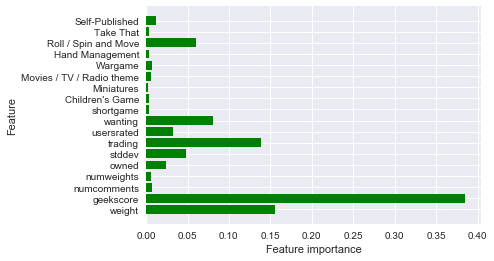

In [82]:
#feature importance for the Random Forest Regression model
x=rfr.feature_importances_ > 0.002
features=dfaverage.columns[x]
coefficients=list(rfr.feature_importances_[x])
n_features = dfaverage.columns[x].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="green")
plt.yticks(np.arange(n_features), features)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

# Gametype Classification Model

In [84]:
from sklearn.model_selection import train_test_split
dfgt=df_with_dummies.drop(["Euro", "War"], axis=1) #make a dataframe for this classification set

X_trainval, X_test, y_trainval, y_test=train_test_split(dfgt, dfy.gametype, random_state=0, train_size=.7) #train/test split
bestscore=0
from sklearn.linear_model import LogisticRegression
X_train, X_val, y_train, y_val=train_test_split(X_trainval, y_trainval, random_state=0) #split includes validation data as well
Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10]
for c in Cs:
    lr=LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    score=lr.score(X_val, y_val)
    if score > bestscore:
        bestscore=score
        best_c=c
print("Best Accuracy from CV:{}".format(bestscore))
print("Best C from CV: {}".format(best_c))
# tuning a simple linear regression model

Best Accuracy from CV:0.7299426934097422
Best C from CV: 10


In [85]:
#performance of the simple logistic regression model
lr=LogisticRegression(C=10, class_weight="balanced")
lr.fit(X_trainval, y_trainval)
print("Accuracy Score on training data: {}".format(lr.score(X_trainval, y_trainval)))
print("Accuracy Score on test data: {}".format(lr.score(X_test, y_test)))

Accuracy Score on training data: 0.7086741090084174
Accuracy Score on test data: 0.7085945117704415


In [16]:
#tuning the Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test=train_test_split(dfgt, dfy.gametype, random_state=0, train_size=.7)
parameters={"min_samples_leaf":[10,11,12,13,14,15], "max_depth":[21,22,23,24,25,26,27,28], "max_leaf_nodes":[ 83,84, 85,86,87,88, 90, 91, 95, 97]}
rfc=RandomForestClassifier(n_estimators=5, class_weight="balanced")
clf=GridSearchCV(rfc, parameters, cv=kfold, scoring="accuracy", n_jobs=4)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 22, 'max_leaf_nodes': 95, 'min_samples_leaf': 14}

In [86]:
#accuracy of the Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier
dfy.gametype=dfy.gametype.str.get_dummies()
X_train, X_test, y_train, y_test=train_test_split(dfgt, dfy.gametype, random_state=0, train_size=.7)
rf=RandomForestClassifier(n_estimators =100,max_depth=22, min_samples_leaf=14, max_leaf_nodes=95, class_weight="balanced")
rf=rf.fit(X_train, y_train)
print("Accuracy on Training Set: {}".format(rf.score(X_train, y_train)))
print("Accuracy on Test Set: {}".format(rf.score(X_test, y_test)))

Accuracy on Training Set: 0.7323144886872426
Accuracy on Test Set: 0.7122161860983424


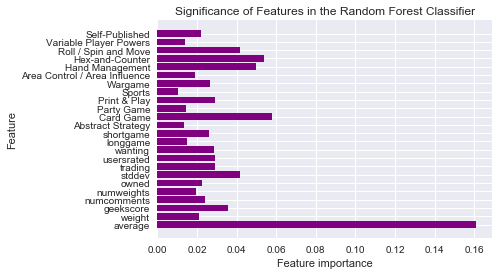

In [87]:
x=rf.feature_importances_ > 0.01
features=df_with_dummies.columns[x]
coefficients=list(rf.feature_importances_[x])
n_features = df_with_dummies.columns[x].values.shape[0]
plt.barh(range(n_features), coefficients, align="center", color="purple")
plt.yticks(np.arange(n_features), features)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Significance of Features in the Random Forest Classifier")

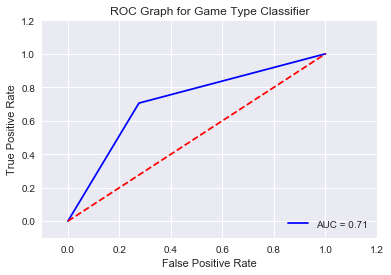

In [97]:
#code to build a ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred=rf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC Graph for Game Type Classifier')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Naive Bayes Classifier of Gametype

In [89]:
text=games[["description", "publisher", "mechanic", "category", "gametype"]]
text["docs"]=text["publisher"]+" "+text["mechanic"]+" "+text["category"]
#makes a dataframe of relevant text data

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
def make_xy(text, y_value, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    X=X.tocsc()
    y=(y_value=="Euro").values.astype(np.int)
    return X,y
X,y=make_xy(text.docs, text.gametype)
#vectorizes the text data

In [91]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += clf.score(X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [92]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(text.shape[0]), train_size=0.7)
mask = np.zeros(text.shape[0], dtype=np.bool)
mask[itest] = True

In [93]:
#tuning the model based on alpha and min_df
alphas = [.0001, .001, .01, 1, 10] #alpha
best_min_df = [1,2,3,4,5] # mindf
scores_list=[]
#Find the best value for alpha and min_df, and the best classifier
results_list=[]
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for df in best_min_df:
        vectorizer = CountVectorizer(min_df=df)
        Xthis, ythis = make_xy(text["docs"], text.gametype, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf=MultinomialNB(alpha=alpha)
        score=cv_score(clf,Xtrainthis, ytrainthis)
        scores_list.append((score,alpha, df))
for i in scores_list:
    if i[0] > maxscore:
        maxscore=i[0]
        results_list.append(i)
x=len(results_list)-1
best_alpha=results_list[x][1]
best_min_df=results_list[x][2]

In [95]:
vectorizer = CountVectorizer(min_df=1, stop_words="english")
X, y = make_xy(text["docs"], text.gametype, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=.001).fit(xtrain, ytrain)
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.875749
Accuracy on test data:     0.807594


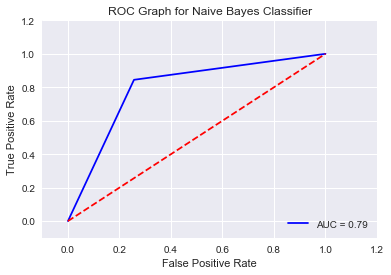

In [98]:
#making a ROC curve for this classifier
y_pred=clf.predict(xtest)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC Graph for Naive Bayes Classifier')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
#confusion matrix for this dataset
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[4565 1574]
 [1649 8963]]


In [100]:
#spits out the top words associated with Euro/War games respectively--mostly publishers
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Euro words\t     P(Euro | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("War words\t     P(War | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Euro words	     P(Euro | word)
             friends 1.00
                huch 1.00
                 lps 1.00
              polska 1.00
              goblin 1.00
               uniti 1.00
               rebel 1.00
                  pl 1.00
                odds 1.00
           filosofia 1.00
War words	     P(War | word)
                sons 0.00
                otto 0.00
               maier 0.00
         altenburger 0.00
                 ass 0.00
                john 0.00
                 tsr 0.00
                  3w 0.00
                 spi 0.00
        publications 0.00
